# Load Libraries

In [1]:
%load_ext jupyter_black

In [2]:
!pip install -q fcapy==0.1.4.1
!pip install -q frozendict==2.3.8
!pip install -q numpy==1.26.4
!pip install -q ipynb
!pip install -q sparselinear
!pip install -q bitsets==0.8.3
!pip install -q bitarray==2.9.3
!pip install -q catboost
!pip install -q xgboost

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.1.1.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.1.1.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-2.1.1.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [3]:
import torch
import warnings
import numpy as np
import pandas as pd

from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

plt.rcParams["figure.facecolor"] = (1, 1, 1, 1)
from IPython.display import clear_output

import neural_lib as nl

warnings.filterwarnings("ignore")

# Data Load and Exploration

In [4]:
TEST_SIZE = 0.25
RANDOM_STATE = 42

torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [5]:
data = pd.read_csv("../data/Credit Score Classification Dataset.csv")
data.head()

,Age,Gender,Income,Education,Marital Status,Number of Children,Home Ownership,Credit Score
0,25,Female,50000,Bachelor's Degree,Single,0,Rented,High
1,30,Male,100000,Master's Degree,Married,2,Owned,High
2,35,Female,75000,Doctorate,Married,1,Owned,High
3,40,Male,125000,High School Diploma,Single,0,Owned,High
4,45,Female,100000,Bachelor's Degree,Married,3,Owned,High


In [6]:
print("----------SHAPE----------")
print(data.shape)
print("----------NANS----------")
print(data.isna().sum())
print("----------COLUMNS----------")
print(data.dtypes)
print("----------UNIQUE----------")
unique_dict = {}
for column in data.columns:
    unique_dict[column] = data[column].nunique()
pd.Series(unique_dict)

----------SHAPE----------
(164, 8)
----------NANS----------
Age                   0
Gender                0
Income                0
Education             0
Marital Status        0
Number of Children    0
Home Ownership        0
Credit Score          0
dtype: int64
----------COLUMNS----------
Age                    int64
Gender                object
Income                 int64
Education             object
Marital Status        object
Number of Children     int64
Home Ownership        object
Credit Score          object
dtype: object
----------UNIQUE----------


Age                   29
Gender                 2
Income                52
Education              5
Marital Status         2
Number of Children     4
Home Ownership         2
Credit Score           3
dtype: int64

In [7]:
for column in data.columns:
    print(column + ": " + str(list(data[column].unique())))

Age: [25, 30, 35, 40, 45, 50, 26, 31, 36, 41, 46, 51, 27, 32, 37, 42, 47, 52, 28, 33, 38, 43, 48, 53, 29, 34, 39, 44, 49]
Gender: ['Female', 'Male']
Income: [50000, 100000, 75000, 125000, 150000, 40000, 60000, 80000, 105000, 90000, 135000, 35000, 55000, 70000, 95000, 85000, 30000, 65000, 115000, 25000, 45000, 130000, 155000, 110000, 140000, 37500, 57500, 72500, 32500, 52500, 67500, 92500, 82500, 122500, 27500, 47500, 62500, 87500, 77500, 112500, 117500, 142500, 160000, 97500, 145000, 162500, 120000, 102500, 137500, 127500, 82000, 68000]
Education: ["Bachelor's Degree", "Master's Degree", 'Doctorate', 'High School Diploma', "Associate's Degree"]
Marital Status: ['Single', 'Married']
Number of Children: [0, 2, 1, 3]
Home Ownership: ['Rented', 'Owned']
Credit Score: ['High', 'Average', 'Low']


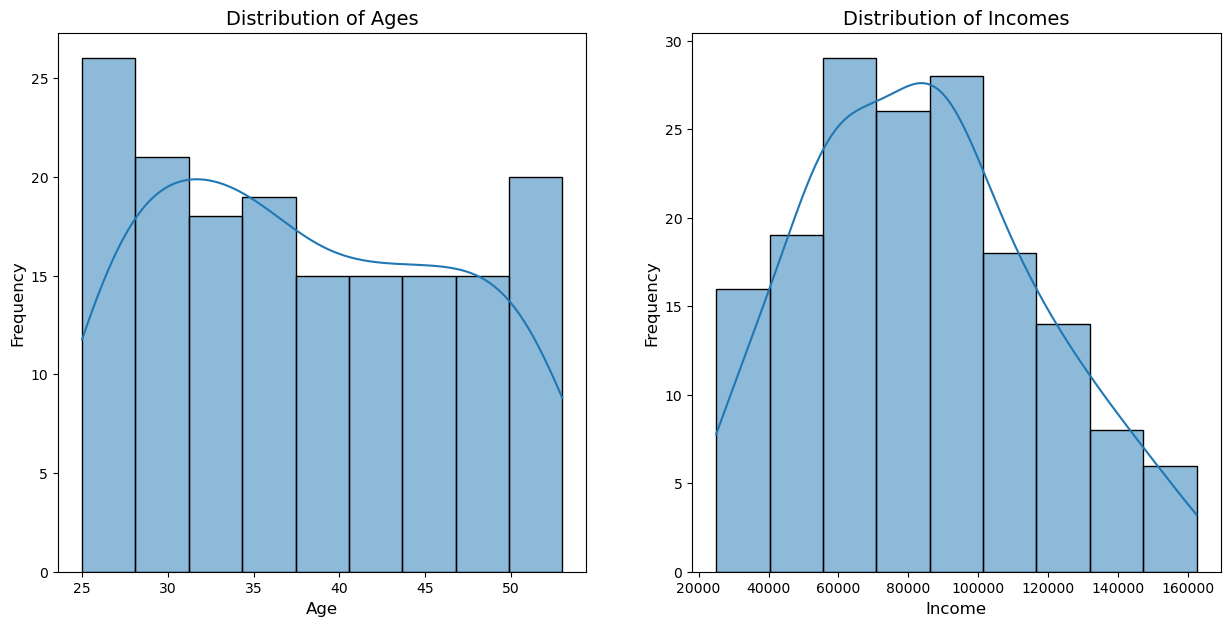

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

sns.histplot(data["Age"], kde=True, ax=ax1)
ax1.set_title("Distribution of Ages", size=14)
ax1.set_xlabel("Age", size=12)
ax1.set_ylabel("Frequency", size=12)

sns.histplot(data["Income"], kde=True, ax=ax2)
ax2.set_title("Distribution of Incomes", size=14)
ax2.set_xlabel("Income", size=12)
ax2.set_ylabel("Frequency", size=12)

plt.show()

In [9]:
print("Ages: ", sorted(data["Age"].unique().tolist()))
print("Income: ", sorted(data["Income"].unique().tolist()))

Ages:  [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Income:  [25000, 27500, 30000, 32500, 35000, 37500, 40000, 45000, 47500, 50000, 52500, 55000, 57500, 60000, 62500, 65000, 67500, 68000, 70000, 72500, 75000, 77500, 80000, 82000, 82500, 85000, 87500, 90000, 92500, 95000, 97500, 100000, 102500, 105000, 110000, 112500, 115000, 117500, 120000, 122500, 125000, 127500, 130000, 135000, 137500, 140000, 142500, 145000, 150000, 155000, 160000, 162500]


### Feature Engineering

In [10]:
data["Has Children"] = data["Number of Children"].apply(
    lambda x: False if x == 0 else True
)

data["is Not High"] = data["Credit Score"].apply(
    lambda x: False if x == "High" else True
)

data = data.drop(["Number of Children", "Credit Score"], axis=1)

In [11]:
data_v1 = data

In [12]:
bins = [24, 34, 44, np.inf]
labels = ["25-33", "34-43", "44-53"]
data_v1["Age Group"] = pd.cut(data_v1["Age"], bins=bins, labels=labels)
data_v1 = data_v1.drop("Age", axis=1)
data_v1.head()

,Gender,Income,Education,Marital Status,Home Ownership,Has Children,is Not High,Age Group
0,Female,50000,Bachelor's Degree,Single,Rented,False,False,25-33
1,Male,100000,Master's Degree,Married,Owned,True,False,25-33
2,Female,75000,Doctorate,Married,Owned,True,False,34-43
3,Male,125000,High School Diploma,Single,Owned,False,False,34-43
4,Female,100000,Bachelor's Degree,Married,Owned,True,False,44-53


In [13]:
bins = [-1, 75000, 125000, np.inf]
labels = ["25k-74k", "75k-124k", "125k-174k"]
data_v1["Income Class"] = pd.cut(data_v1["Income"], bins=bins, labels=labels)
data_v1 = data_v1.drop("Income", axis=1)
data_v1.head()

,Gender,Education,Marital Status,Home Ownership,Has Children,is Not High,Age Group,Income Class
0,Female,Bachelor's Degree,Single,Rented,False,False,25-33,25k-74k
1,Male,Master's Degree,Married,Owned,True,False,25-33,75k-124k
2,Female,Doctorate,Married,Owned,True,False,34-43,25k-74k
3,Male,High School Diploma,Single,Owned,False,False,34-43,75k-124k
4,Female,Bachelor's Degree,Married,Owned,True,False,44-53,75k-124k


In [14]:
for column in data_v1.columns:
    print(data_v1[column].value_counts())
    print()

Gender
Female    86
Male      78
Name: count, dtype: int64

Education
Bachelor's Degree      42
Master's Degree        36
Doctorate              31
High School Diploma    30
Associate's Degree     25
Name: count, dtype: int64

Marital Status
Married    87
Single     77
Name: count, dtype: int64

Home Ownership
Owned     111
Rented     53
Name: count, dtype: int64

Has Children
False    97
True     67
Name: count, dtype: int64

is Not High
False    113
True      51
Name: count, dtype: int64

Age Group
25-33    65
34-43    54
44-53    45
Name: count, dtype: int64

Income Class
75k-124k     75
25k-74k      70
125k-174k    19
Name: count, dtype: int64



In [15]:
data_v1 = pd.get_dummies(data_v1, drop_first=True)
data_v1.head()

,Has Children,is Not High,Gender_Male,Education_Bachelor's Degree,Education_Doctorate,Education_High School Diploma,Education_Master's Degree,Marital Status_Single,Home Ownership_Rented,Age Group_34-43,Age Group_44-53,Income Class_75k-124k,Income Class_125k-174k
0,False,False,False,True,False,False,False,True,True,False,False,False,False
1,True,False,True,False,False,False,True,False,False,False,False,True,False
2,True,False,False,False,True,False,False,False,False,True,False,False,False
3,False,False,True,False,False,True,False,True,False,True,False,True,False
4,True,False,False,True,False,False,False,False,False,False,True,True,False


In [16]:
print(data_v1.columns)

Index(['Has Children', 'is Not High', 'Gender_Male',
       'Education_Bachelor's Degree', 'Education_Doctorate',
       'Education_High School Diploma', 'Education_Master's Degree',
       'Marital Status_Single', 'Home Ownership_Rented', 'Age Group_34-43',
       'Age Group_44-53', 'Income Class_75k-124k', 'Income Class_125k-174k'],
      dtype='object')


In [17]:
X = data_v1.drop("is Not High", axis=1)
y = data_v1["is Not High"]

indices = pd.Series([f"case{i}" for i in range(data_v1.shape[0])])
columns = {col: "feat" + str(i + 1) for i, col in enumerate(X.columns)}
# X = X.join(data_high["Not High Score"])
X = X.set_index([indices])
X = X.rename(columns=columns)
X.head()

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12
case0,False,False,True,False,False,False,True,True,False,False,False,False
case1,True,True,False,False,False,True,False,False,False,False,True,False
case2,True,False,False,True,False,False,False,False,True,False,False,False
case3,False,True,False,False,True,False,True,False,True,False,True,False
case4,True,False,True,False,False,False,False,False,False,True,True,False


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True, stratify=y
)

# Classical ML Models

In [19]:
def print_f1_score(y_train, y_train_pred, y_test, y_test_pred):
    y_train_pred = y_train_pred.astype(y_train.dtype)
    y_test_pred = y_test_pred.astype(y_test.dtype)
    print("Train: F1 score =", f1_score(y_train, y_train_pred))
    print("Test:  F1 score =", f1_score(y_test, y_test_pred))

In [20]:
def conf_matrices(y_train, y_train_pred, y_test, y_test_pred):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    y_train_pred = y_train_pred.astype(y_train.dtype)
    y_test_pred = y_test_pred.astype(y_test.dtype)

    sns.heatmap(
        confusion_matrix(y_train, y_train_pred),
        annot=True,
        linewidth=0.7,
        linecolor="black",
        fmt="g",
        cmap="BuPu",
        ax=ax1,
    )
    ax1.set_title("Confustion Matrix on Train", size=14)
    ax1.set_xlabel("y_pred", size=12)
    ax1.set_ylabel("y_true", size=12)

    sns.heatmap(
        confusion_matrix(y_test, y_test_pred),
        annot=True,
        linewidth=0.7,
        linecolor="black",
        fmt="g",
        cmap="BuPu",
        ax=ax2,
    )
    ax2.set_title("Confustion Matrix on Test", size=14)
    ax2.set_xlabel("y_pred", size=12)
    ax2.set_ylabel("y_true", size=12)

    plt.show()

In [21]:
def model_fit_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    return y_train_pred, y_test_pred

Train: F1 score = 0.987012987012987
Test:  F1 score = 0.9166666666666666


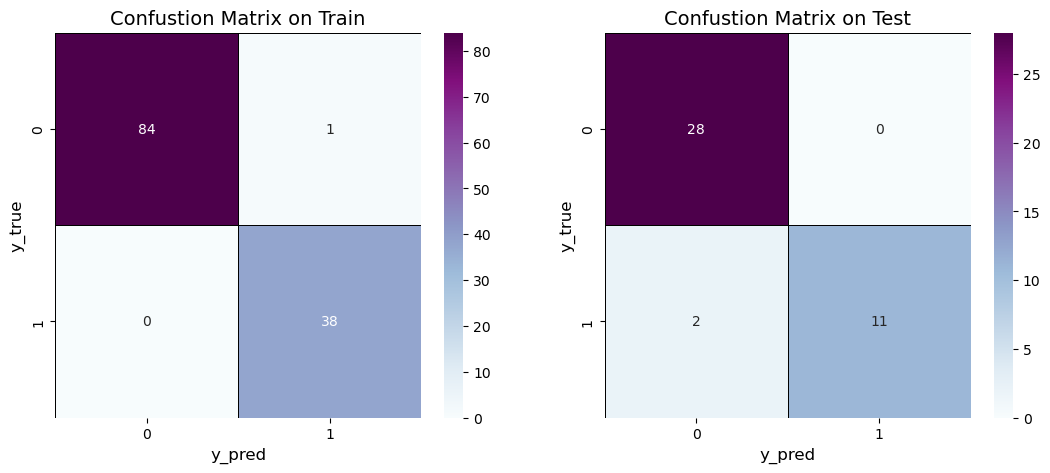

In [22]:
y_train_pred, y_test_pred = model_fit_predict(
    DecisionTreeClassifier(random_state=RANDOM_STATE), X_train, y_train, X_test
)
print_f1_score(y_train, y_train_pred, y_test, y_test_pred)
conf_matrices(y_train, y_train_pred, y_test, y_test_pred)

Train: F1 score = 0.987012987012987
Test:  F1 score = 0.9166666666666666


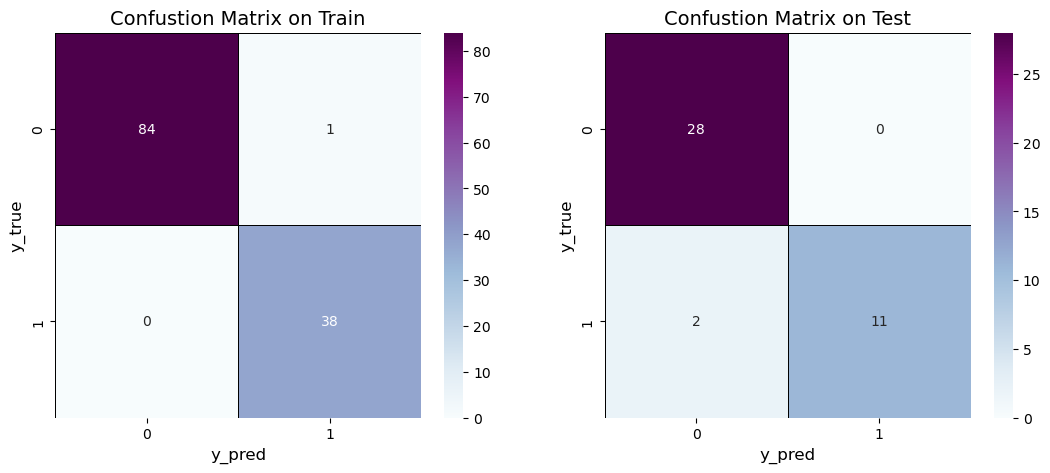

In [23]:
y_train_pred, y_test_pred = model_fit_predict(
    RandomForestClassifier(random_state=RANDOM_STATE), X_train, y_train, X_test
)
print_f1_score(y_train, y_train_pred, y_test, y_test_pred)
conf_matrices(y_train, y_train_pred, y_test, y_test_pred)

Train: F1 score = 0.987012987012987
Test:  F1 score = 0.88


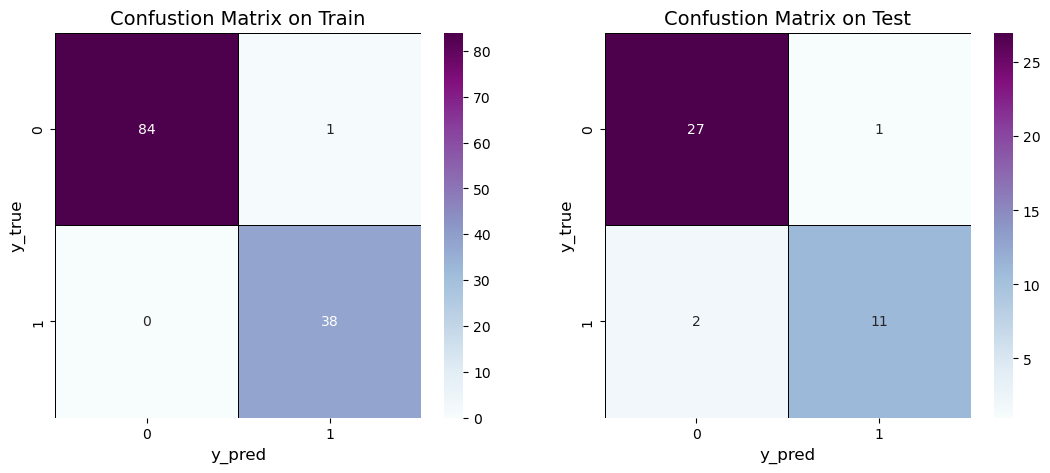

In [24]:
y_train_pred, y_test_pred = model_fit_predict(
    KNeighborsClassifier(), X_train, y_train, X_test
)
print_f1_score(y_train, y_train_pred, y_test, y_test_pred)
conf_matrices(y_train, y_train_pred, y_test, y_test_pred)

Train: F1 score = 0.987012987012987
Test:  F1 score = 0.9166666666666666


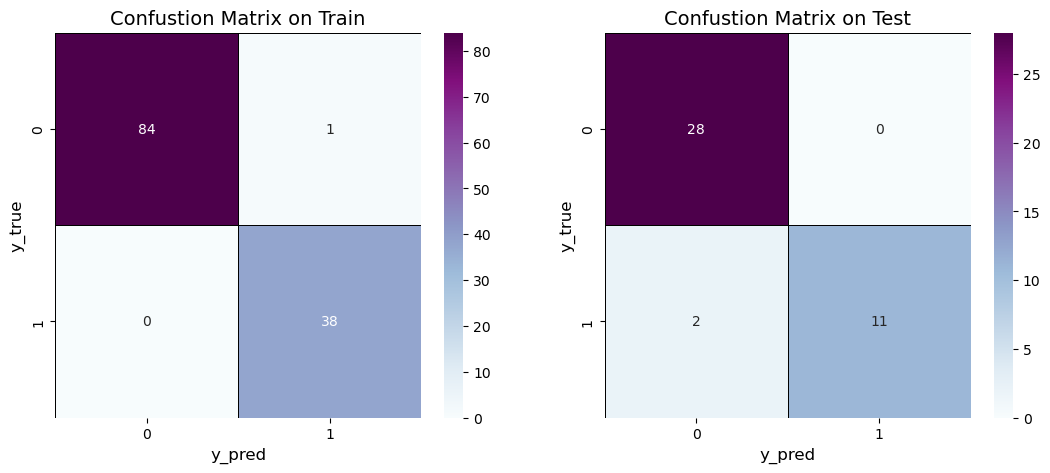

In [25]:
y_train_pred, y_test_pred = model_fit_predict(
    LogisticRegression(random_state=RANDOM_STATE), X_train, y_train, X_test
)
print_f1_score(y_train, y_train_pred, y_test, y_test_pred)
conf_matrices(y_train, y_train_pred, y_test, y_test_pred)

Train: F1 score = 0.987012987012987
Test:  F1 score = 0.9166666666666666


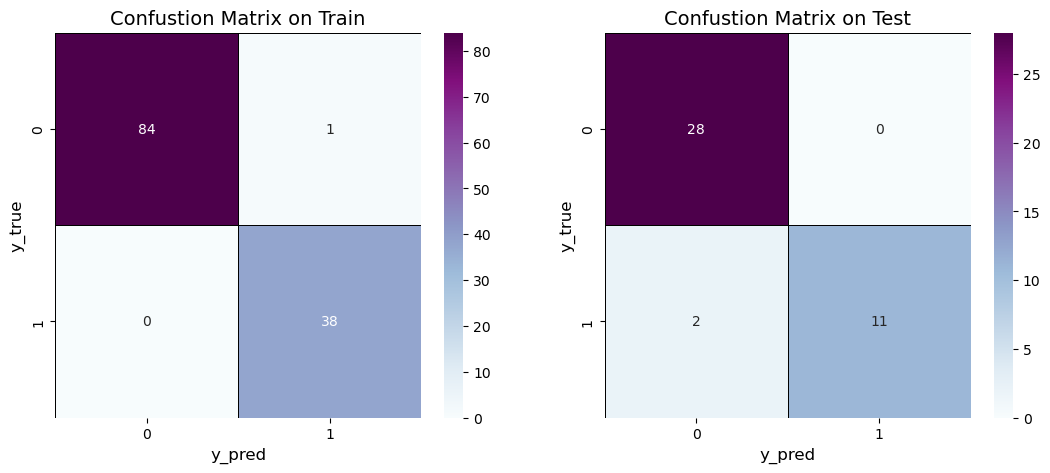

In [26]:
catboost_clf = CatBoostClassifier(random_state=RANDOM_STATE)
catboost_clf.fit(X_train.astype(int), y_train.astype(int), verbose=False)
y_train_pred = catboost_clf.predict(X_train.astype(int))
y_test_pred = catboost_clf.predict(X_test.astype(int))

print_f1_score(y_train.astype(int), y_train_pred, y_test.astype(int), y_test_pred)
conf_matrices(y_train.astype(int), y_train_pred, y_test.astype(int), y_test_pred)

Train: F1 score = 0.987012987012987
Test:  F1 score = 0.9166666666666666


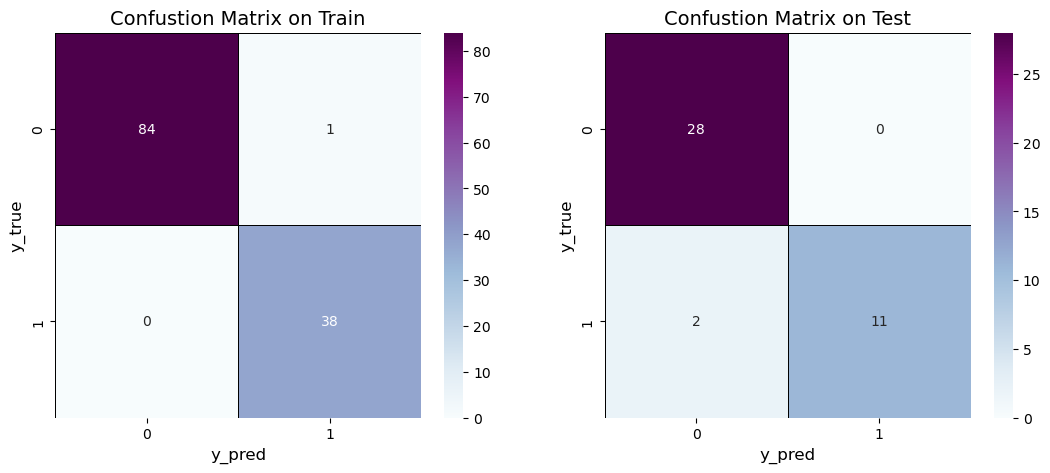

In [27]:
xgboost_clf = XGBClassifier(random_state=RANDOM_STATE)
xgboost_clf.fit(X_train, y_train, verbose=False)
y_train_pred = xgboost_clf.predict(X_train)
y_test_pred = xgboost_clf.predict(X_test)

print_f1_score(y_train, y_train_pred, y_test, y_test_pred)
conf_matrices(y_train, y_train_pred, y_test, y_test_pred)

# Concept Network

### First Attempt

In [28]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (123 objects, 12 attributes, 465 connections)
       |feat1|feat2|feat3|feat4|feat5|...|feat8|feat9|feat10|feat11|feat12|
case113|    X|     |    X|     |     |...|     |    X|      |      |      |
case112|     |    X|     |     |    X|...|    X|     |      |      |      |
case162|     |    X|     |     |     |...|     |    X|      |     X|      |
case78 |     |    X|     |     |    X|...|     |     |     X|      |     X|
case95 |    X|     |     |    X|     |...|     |    X|      |     X|      |
case151|    X|     |     |    X|     |...|     |     |     X|     X|      |
case122|     |     |    X|     |     |...|    X|     |      |      |      |
case98 |     |    X|     |     |     |...|     |     |     X|      |     X|
case81 |    X|     |    X|     |     |...|     |    X|      |      |      |
case26 |    X|     |    X|     |     |...|     |    X|      |      |      |
...........................................................................
............................

In [29]:
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

536

In [30]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures["f1_score"] = f1_score(y_train, y_preds)

concepts_count = 16
best_concepts = list(L.measures["f1_score"].argsort()[::-1][:concepts_count])

assert (
    len({g_i for c in L[best_concepts] for g_i in c.extent_i}) == K_train.n_objects
), "Selected concepts do not cover all train objects"

In [31]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

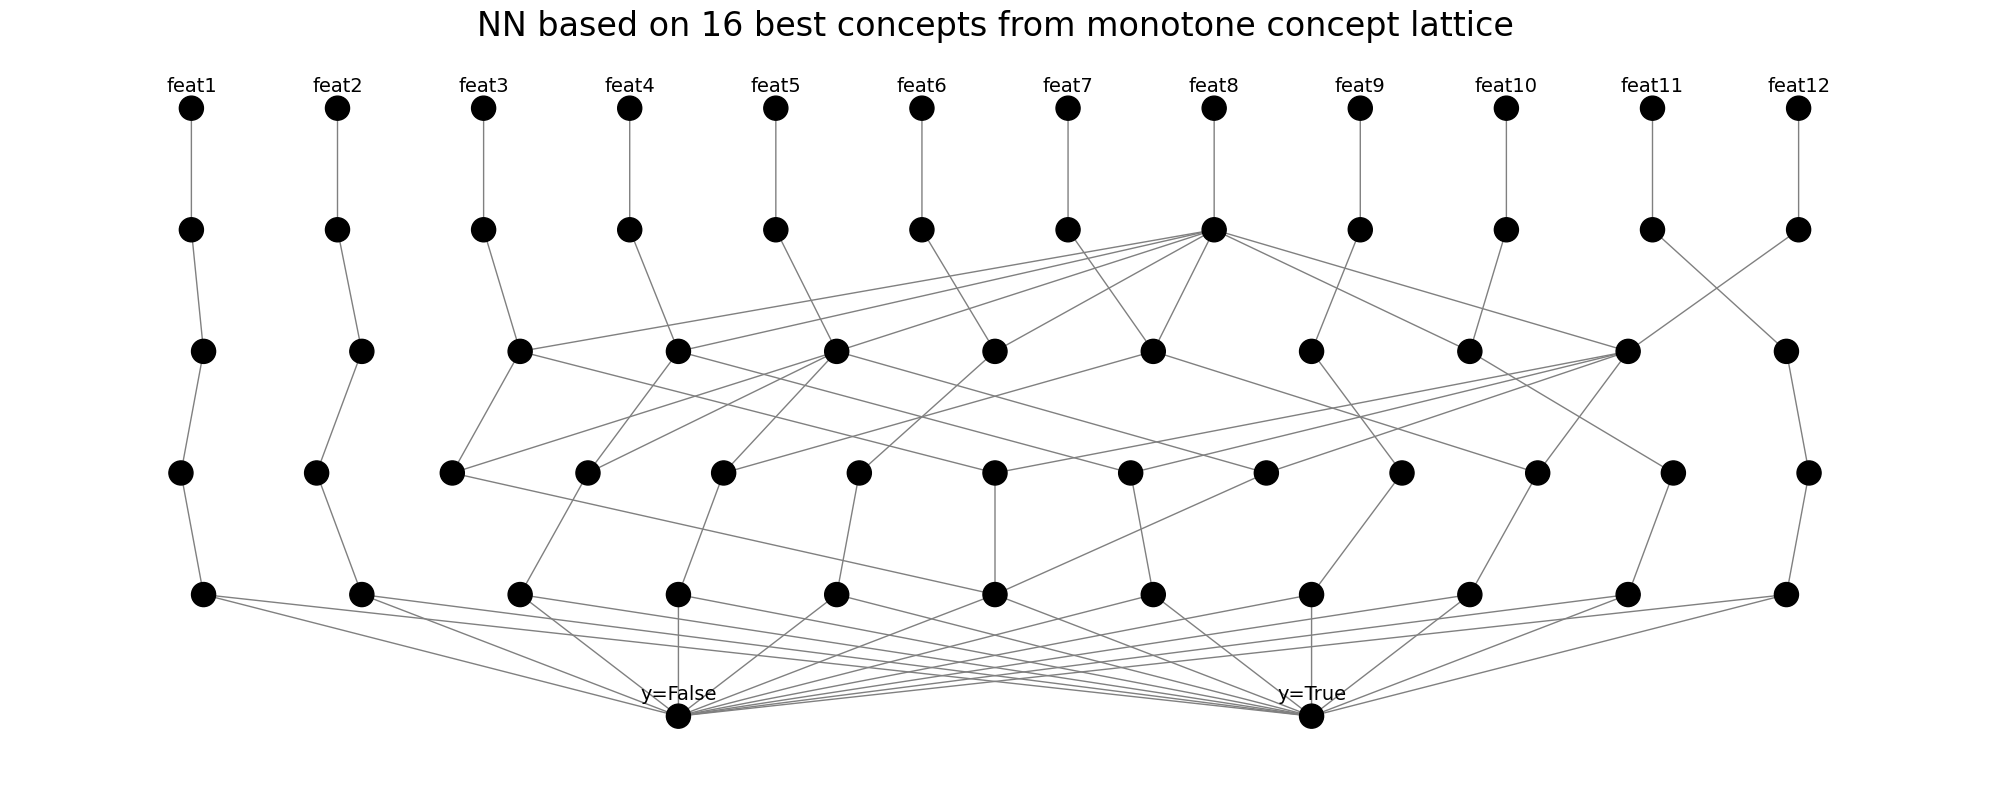

In [32]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))
    + "\n\n",
    edge_cmap="hsv",
)

fig, ax = plt.subplots(figsize=(20, 8))

vis.draw_poset(
    cn.poset,
    ax=ax,
    edge_color="grey",
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(
        el_i, P, set(cn.attributes), only_new_attrs=True
    )
    + "\n\n",
    node_color="black",
)

plt.title(
    f"NN based on {concepts_count} best concepts from monotone concept lattice",
    loc="center",
    size=24,
)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Train: F1 score = 0.9620253164556962
Test:  F1 score = 0.88


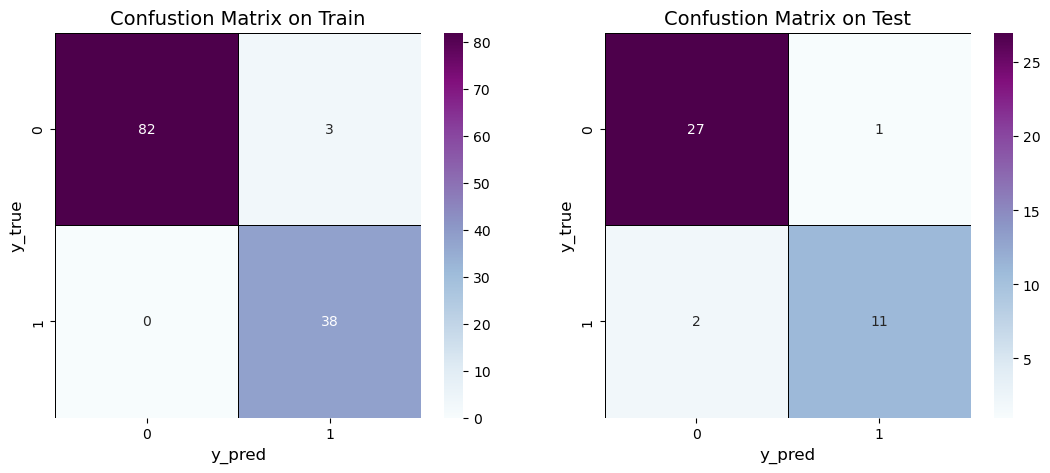

In [33]:
cn.fit(X_train, y_train, n_epochs=2000)

print_f1_score(
    y_train.values,
    cn.predict(X_train).numpy(),
    y_test.values,
    cn.predict(X_test).numpy(),
)
conf_matrices(
    y_train.values,
    cn.predict(X_train).numpy(),
    y_test.values,
    cn.predict(X_test).numpy(),
)

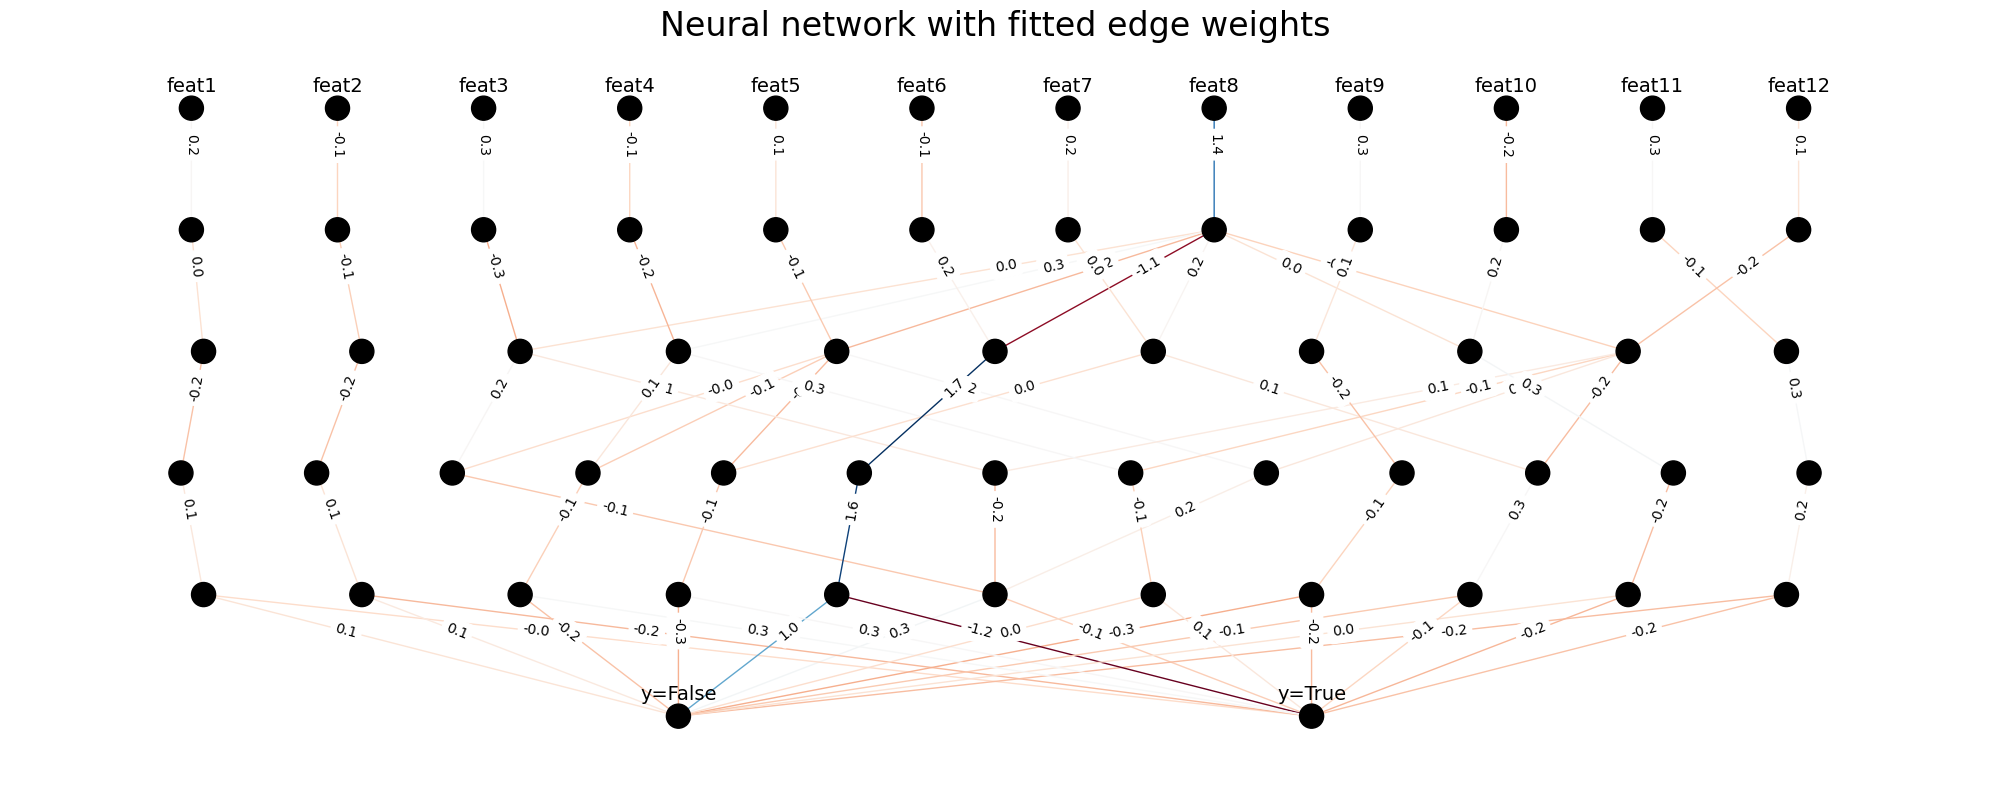

In [34]:
edge_weights = cn.edge_weights_from_network()

fig, ax = plt.subplots(figsize=(20, 8))

vis.draw_poset(
    cn.poset,
    ax=ax,
    node_color="black",
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(
        el_i, P, set(cn.attributes), only_new_attrs=True
    )
    + "\n\n",
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(
    cn.poset.to_networkx(),
    vis.mover.pos,
    {k: f"{v:.1f}" for k, v in edge_weights.items()},
    label_pos=0.7,
)

plt.title("Neural network with fitted edge weights", size=24, loc="center")
plt.tight_layout()
plt.subplots_adjust()
plt.savefig("1_16.png")
plt.show()

### Different Feature Engineering

In [35]:
data_v2 = data

In [36]:
bins = [24, 40, np.inf]
labels = ["young_adult", "adult"]
data_v2["Age Group"] = pd.cut(data_v2["Age"], bins=bins, labels=labels)
data_v2 = data_v2.drop("Age", axis=1)
data_v2.head()

,Gender,Income,Education,Marital Status,Home Ownership,Has Children,is Not High,Age Group
0,Female,50000,Bachelor's Degree,Single,Rented,False,False,young_adult
1,Male,100000,Master's Degree,Married,Owned,True,False,young_adult
2,Female,75000,Doctorate,Married,Owned,True,False,young_adult
3,Male,125000,High School Diploma,Single,Owned,False,False,young_adult
4,Female,100000,Bachelor's Degree,Married,Owned,True,False,adult


In [37]:
bins = [-1, 60000, 100000, np.inf]
labels = ["lower", "middle", "upper"]
data_v2["Income Class"] = pd.cut(data_v2["Income"], bins=bins, labels=labels)
data_v2 = data_v2.drop("Income", axis=1)
data_v2.head()

,Gender,Education,Marital Status,Home Ownership,Has Children,is Not High,Age Group,Income Class
0,Female,Bachelor's Degree,Single,Rented,False,False,young_adult,lower
1,Male,Master's Degree,Married,Owned,True,False,young_adult,middle
2,Female,Doctorate,Married,Owned,True,False,young_adult,middle
3,Male,High School Diploma,Single,Owned,False,False,young_adult,upper
4,Female,Bachelor's Degree,Married,Owned,True,False,adult,middle


In [38]:
data_v2 = pd.get_dummies(data_v2, drop_first=True)
data_v2.head()

,Has Children,is Not High,Gender_Male,Education_Bachelor's Degree,Education_Doctorate,Education_High School Diploma,Education_Master's Degree,Marital Status_Single,Home Ownership_Rented,Age Group_adult,Income Class_middle,Income Class_upper
0,False,False,False,True,False,False,False,True,True,False,False,False
1,True,False,True,False,False,False,True,False,False,False,True,False
2,True,False,False,False,True,False,False,False,False,False,True,False
3,False,False,True,False,False,True,False,True,False,False,False,True
4,True,False,False,True,False,False,False,False,False,True,True,False


In [39]:
X = data_v2.drop("is Not High", axis=1)
y = data_v2["is Not High"]

indices = pd.Series([f"case{i}" for i in range(data_v2.shape[0])])
columns = {col: "feat" + str(i + 1) for i, col in enumerate(X.columns)}
X = X.set_index([indices])
X = X.rename(columns=columns)
X.head()

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11
case0,False,False,True,False,False,False,True,True,False,False,False
case1,True,True,False,False,False,True,False,False,False,True,False
case2,True,False,False,True,False,False,False,False,False,True,False
case3,False,True,False,False,True,False,True,False,False,False,True
case4,True,False,True,False,False,False,False,False,True,True,False


In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True, stratify=y
)

### Second Attempt

In [41]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (123 objects, 11 attributes, 457 connections)
       |feat1|feat2|feat3|feat4|feat5|...|feat7|feat8|feat9|feat10|feat11|
case113|    X|     |    X|     |     |...|     |     |     |     X|      |
case112|     |    X|     |     |    X|...|    X|    X|     |      |      |
case162|     |    X|     |     |     |...|    X|     |    X|     X|      |
case78 |     |    X|     |     |    X|...|     |     |    X|      |     X|
case95 |    X|     |     |    X|     |...|     |     |     |     X|      |
case151|    X|     |     |    X|     |...|     |     |    X|     X|      |
case122|     |     |    X|     |     |...|    X|    X|     |      |      |
case98 |     |    X|     |     |     |...|     |     |    X|      |     X|
case81 |    X|     |    X|     |     |...|     |     |     |     X|      |
case26 |    X|     |    X|     |     |...|     |     |     |      |      |
..........................................................................
........................................

In [42]:
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

335

In [43]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures["f1_score"] = f1_score(y_train, y_preds)

concepts_count = 9
best_concepts = list(L.measures["f1_score"].argsort()[::-1][:concepts_count])

assert (
    len({g_i for c in L[best_concepts] for g_i in c.extent_i}) == K_train.n_objects
), "Selected concepts do not cover all train objects"

In [44]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

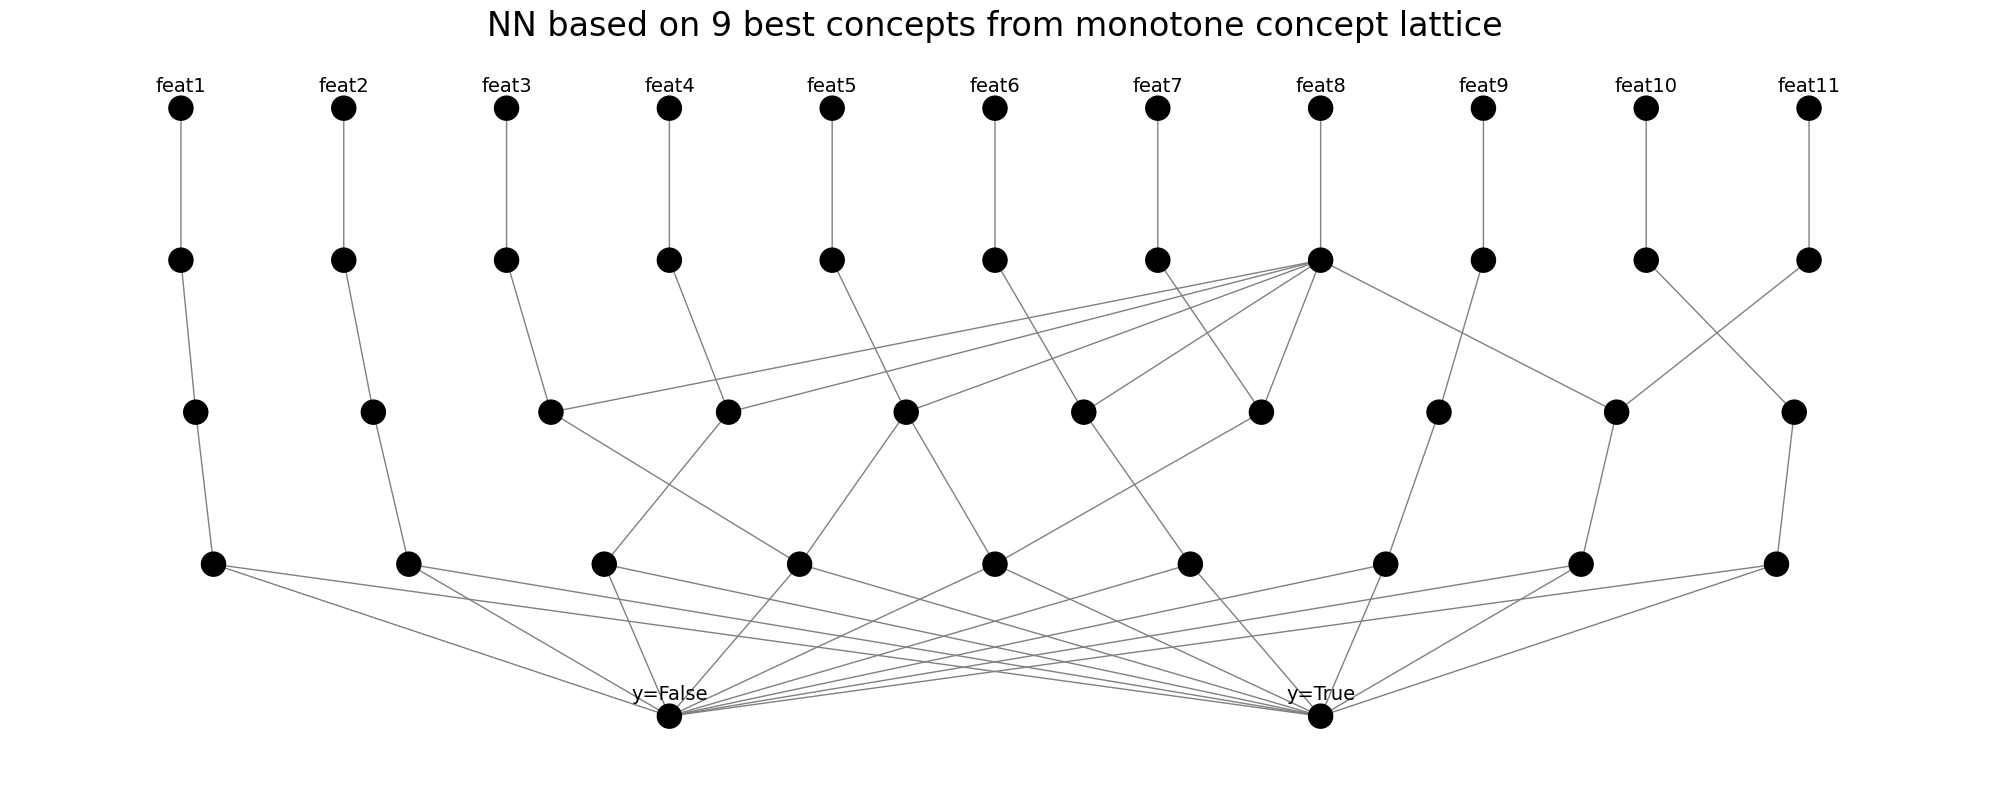

In [45]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))
    + "\n\n",
    edge_cmap="hsv",
)

fig, ax = plt.subplots(figsize=(20, 8))

vis.draw_poset(
    cn.poset,
    ax=ax,
    edge_color="grey",
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(
        el_i, P, set(cn.attributes), only_new_attrs=True
    )
    + "\n\n",
    node_color="black",
)

plt.title(
    f"NN based on {concepts_count} best concepts from monotone concept lattice",
    loc="center",
    size=24,
)

plt.subplots_adjust()
plt.tight_layout()

plt.show()

Train: F1 score = 0.9620253164556962
Test:  F1 score = 0.88


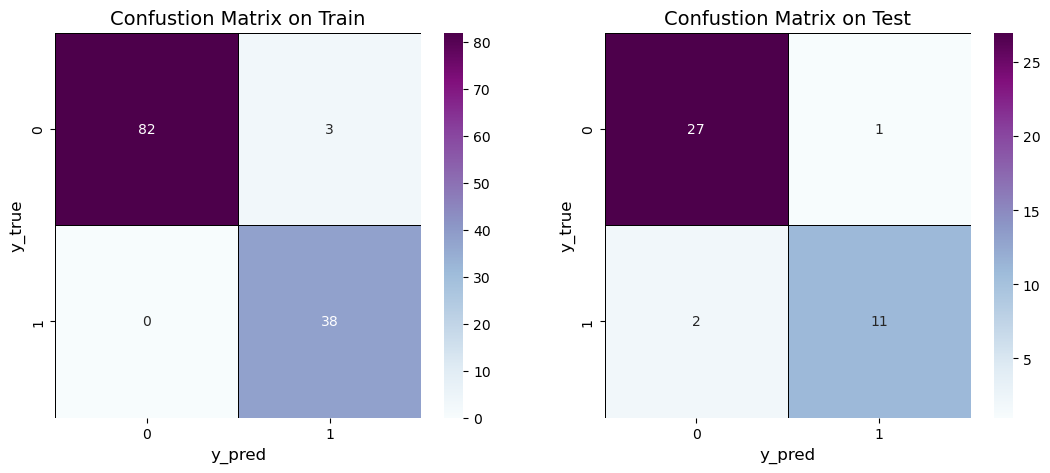

In [46]:
cn.fit(X_train, y_train, n_epochs=2000)

print_f1_score(
    y_train.values,
    cn.predict(X_train).numpy(),
    y_test.values,
    cn.predict(X_test).numpy(),
)
conf_matrices(
    y_train.values,
    cn.predict(X_train).numpy(),
    y_test.values,
    cn.predict(X_test).numpy(),
)

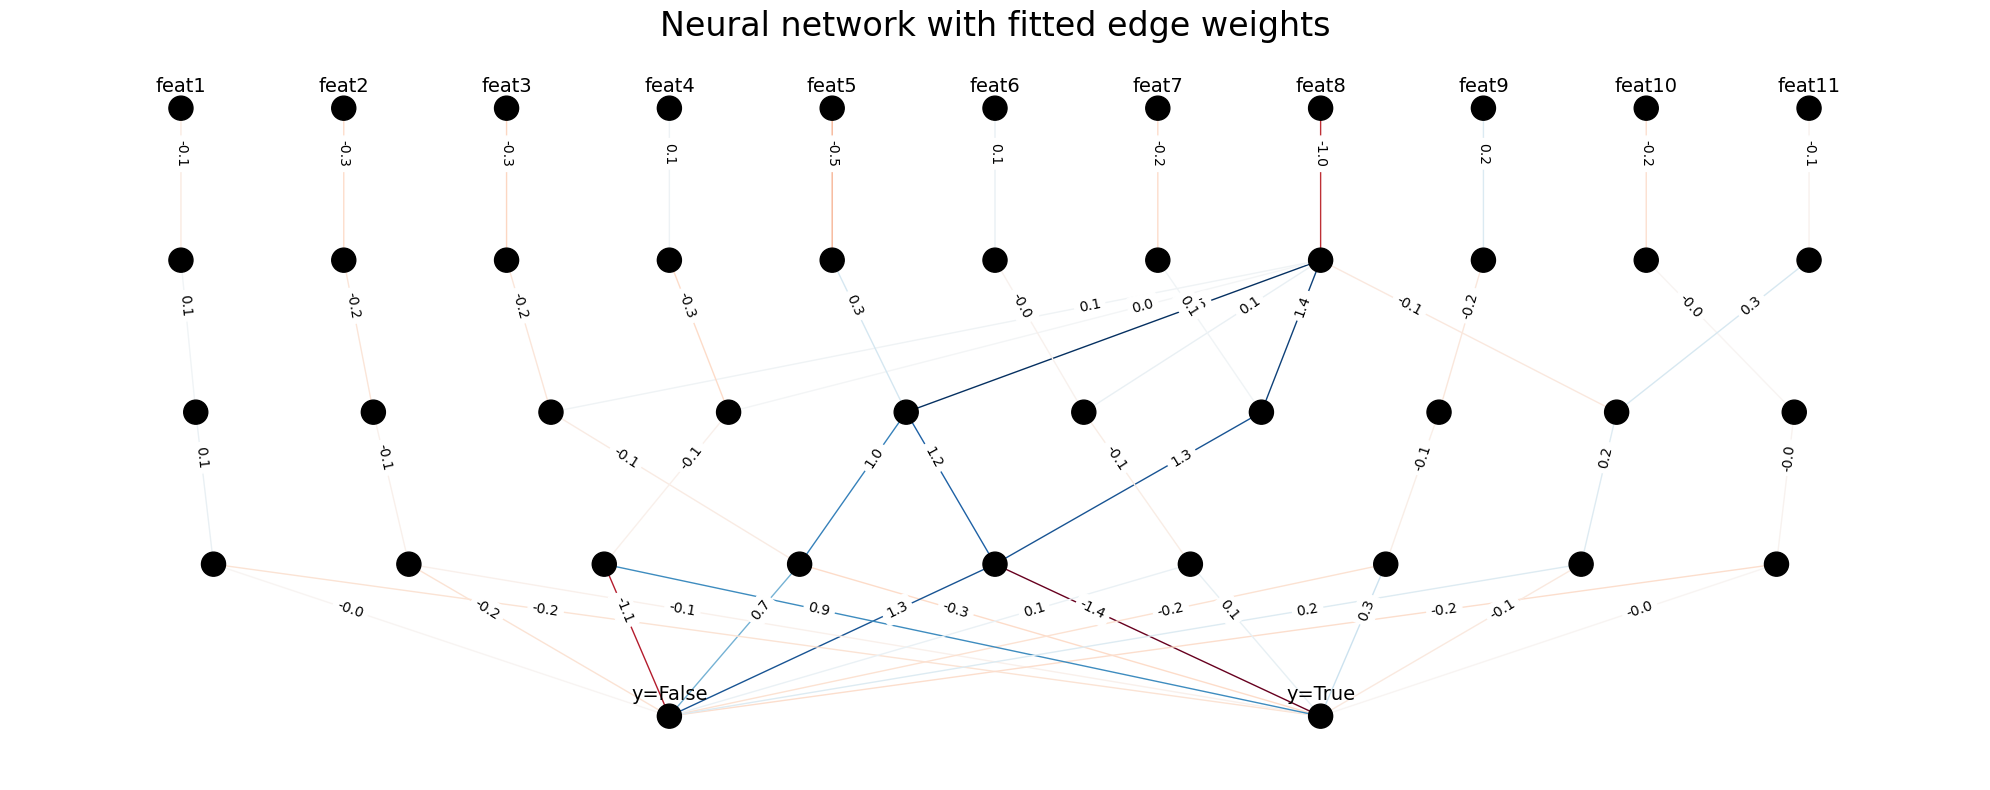

In [47]:
edge_weights = cn.edge_weights_from_network()

fig, ax = plt.subplots(figsize=(20, 8))

vis.draw_poset(
    cn.poset,
    ax=ax,
    node_color="black",
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(
        el_i, P, set(cn.attributes), only_new_attrs=True
    )
    + "\n\n",
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(
    cn.poset.to_networkx(),
    vis.mover.pos,
    {k: f"{v:.1f}" for k, v in edge_weights.items()},
    label_pos=0.7,
)

plt.title("Neural network with fitted edge weights", size=24, loc="center")
plt.tight_layout()
plt.subplots_adjust()
plt.savefig("2_9.png")
plt.show()

### Third Attempt with Nonlinearities

Train: F1 score = 0.987012987012987
Test:  F1 score = 0.88


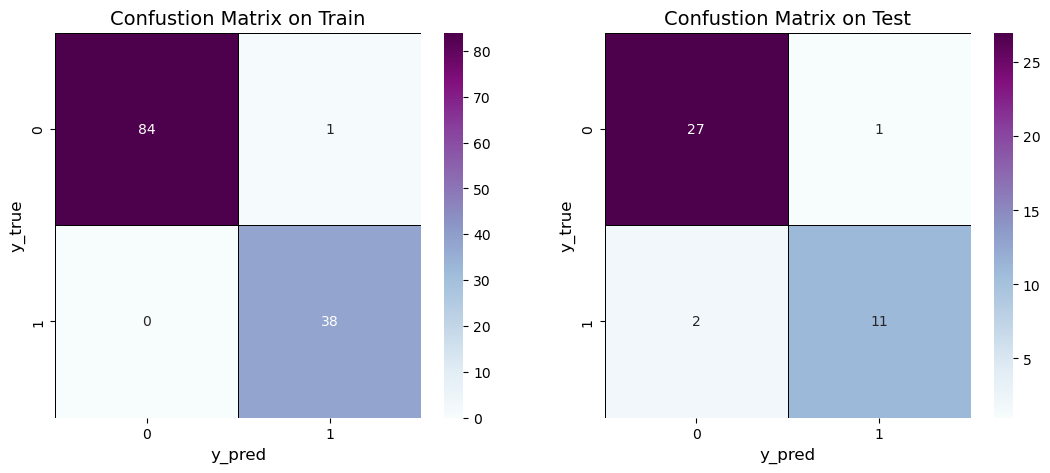

In [48]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

cn.fit(X_train, y_train, n_epochs=2000, nonlinearity=torch.nn.Tanh)

print_f1_score(
    y_train.values,
    cn.predict(X_train).numpy(),
    y_test.values,
    cn.predict(X_test).numpy(),
)
conf_matrices(
    y_train.values,
    cn.predict(X_train).numpy(),
    y_test.values,
    cn.predict(X_test).numpy(),
)

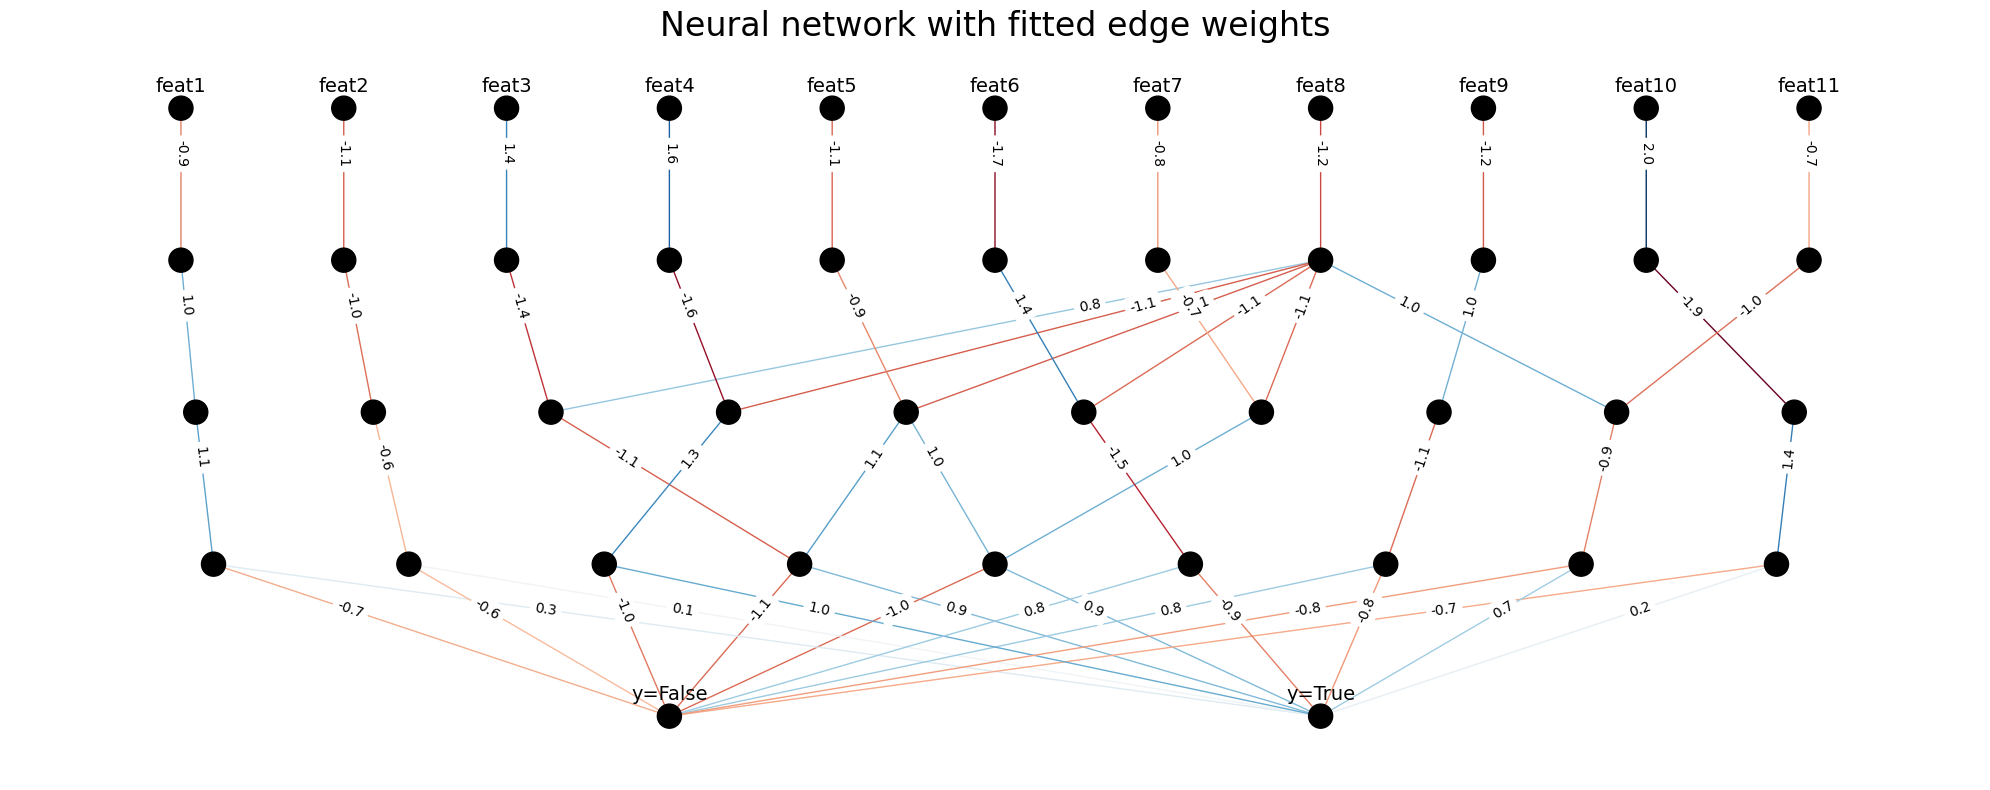

In [49]:
edge_weights = cn.edge_weights_from_network()

fig, ax = plt.subplots(figsize=(20, 8))

vis.draw_poset(
    cn.poset,
    ax=ax,
    node_color="black",
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(
        el_i, P, set(cn.attributes), only_new_attrs=True
    )
    + "\n\n",
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(
    cn.poset.to_networkx(),
    vis.mover.pos,
    {k: f"{v:.1f}" for k, v in edge_weights.items()},
    label_pos=0.7,
)

plt.title("Neural network with fitted edge weights", size=24, loc="center")
plt.tight_layout()
plt.subplots_adjust()
plt.savefig("2_9_sig.png")
plt.show()